# Historical coverage for data sources in OpenSAFELY

This notebook provides information about historical coverage of events in the OpenSAFELY-TPP database. 

## Data sources
Data sources are listed below, with the table name in the database given in brackets:

* Positive or negative SARS-CoV2 test, first tests only, from SGSS (`SGSS_Positive` and `SGSS_Negative`)
* Positive or negative SARS-CoV2 test, any test, from SGSS (`SGSS_AllTests_Positive` and `SGSS_AllTests_Negative`)
* A&E attendance, from SUS Emergency Care Data (`EC`)
* Hospital admission, from SUS Admitted Patient Care Data (`APCS`)
* Covid-related ICU admission, from ICNARC (`ICNARC`)
* Covid-related in-hospital death, from CPNS (`CPNS`)
* All-cause registered deaths, from ONS (`ONS_Deaths`)

Note that for SGSS data, currently only the `SGSS_Negative` and `SGSS_Positive` tables are queriable with a study definition. 
These tables only provide the first known test for any person (with a few unexplained exceptions), so there won't be multiple positive tests per patient in SGSS data. Data for negative test results is unreliable. 
Support for `SGSS_AllTests_Positive` and `SGSS_AllTests_Negative` will be added later. 


In [1]:
## Import libraries

%load_ext autoreload
%autoreload 2

import pyodbc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.dates as mdates
from contextlib import contextmanager
from datetime import date, datetime
from IPython.display import display, Markdown

import sys
sys.path.append('../lib/')
from functions import *

In [2]:
# get server credentials from environment variable

dbconn = os.environ.get('FULL_DATABASE_URL', None).strip('"')

In [3]:
## Import libraries

with closing_connection(dbconn) as cnxn:
    DBbuild = pd.read_sql("""select * from LatestBuildTime""", cnxn)
    latestbuilds = pd.read_sql(
    """
        select BuildDesc as dataset, max(BuildDate) as latest_import from BuildInfo
        group by BuildDesc
    """, cnxn)
    allbuilds = pd.read_sql("""select * from BuildInfo""", cnxn)

# select start and end dates
start_date = pd.to_datetime("2016-01-01", format='%Y-%m-%d')
#start_date = pd.to_datetime("2020-02-01", format='%Y-%m-%d')
end_date = pd.to_datetime(latestbuilds['latest_import'].max(), format='%Y-%m-%d')
run_date = date.today()

## Notebook run date

In [4]:
display(Markdown(f"""This notebook was run on {run_date.strftime('%Y-%m-%d')}.  The information below reflects the state of the OpenSAFELY-TPP as at this date."""))

This notebook was run on 2021-01-27.  The information below reflects the state of the OpenSAFELY-TPP as at this date.

## Event activity in external datasets

Event activity (i.e., counts of patient events such as hospital admissions and deaths) is reported for each external dataset from no earlier than 1 January 2016 up to the notebook run date.

The OpenSAFELY-TPP database only includes patients recently (< 5 years) or actively registered at a GP practice using TPP's SystmOne clinical information system (roughly 40% of English residents). 
Event activity therefore reflects these patients only.

All recorded events are extracted.

In [5]:
def datequery(table, var_table, var_df, from_date):
    query = (
      "select " + var_table + " as " + var_df
    + " from " + table
    + " where " + var_table + " >= convert(date, '" + from_date + "')"
    )
    return query

start_date_text = start_date.strftime('%Y-%m-%d')
#CodedEvent_query = datequery("CodedEvent", "ConsultationDate", "consultation_date", start_date_text)
#Appointment_query = datequery("Appointment", "SeenDate", "appointment_date", start_date_text)
APCS_query = datequery("APCS", "Admission_Date", "hosp_admission_date", start_date_text)
CPNS_query = datequery("CPNS", "DateOfDeath", "cpns_death_date", start_date_text)
EC_query = datequery("EC", "Arrival_Date", "ed_attendance_date", start_date_text)
ICNARC_query = datequery("ICNARC", "CONVERT(date, IcuAdmissionDateTime)", "icu_admission_date", start_date_text)
ONS_query = datequery("ONS_Deaths", "dod", "ons_death_date", start_date_text)
SGSS_query = datequery("""( 
         SELECT * FROM SGSS_Positive 
         UNION
         SELECT * FROM SGSS_Negative
         )  as a""", 
        "Earliest_Specimen_Date", "specimen_date", start_date_text)
SGSSpos_query = datequery("SGSS_Positive", "Earliest_Specimen_Date", "specimen_date", start_date_text)
SGSS_AllTests_query = datequery("""( 
         SELECT * FROM SGSS_AllTests_Positive 
         UNION
         SELECT * FROM SGSS_AllTests_Negative
         )  as a""", 
        "Specimen_Date", "specimen_date", start_date_text)
SGSSpos_AllTests_query = datequery("SGSS_AllTests_Positive", "Specimen_Date", "specimen_date", start_date_text)

with closing_connection(dbconn) as cnxn:
    #CodedEvent_df = pd.read_sql(CodedEvent_query, cnxn, parse_dates=['coded_event_date'])
    #Appointment_df = pd.read_sql(Appointment_query, cnxn, parse_dates=['appointment_date'])
    APCS_df = pd.read_sql(APCS_query, cnxn, parse_dates=['hosp_admission_date'])
    CPNS_df = pd.read_sql(CPNS_query, cnxn, parse_dates=['cpns_death_date'])
    EC_df = pd.read_sql(EC_query, cnxn, parse_dates=['ed_attendance_date'])
    ICNARC_df = pd.read_sql(ICNARC_query, cnxn, parse_dates=['icu_admission_date'])
    ONS_df = pd.read_sql(ONS_query, cnxn, parse_dates=['ons_death_date'])
    SGSS_df = pd.read_sql(SGSS_query, cnxn, parse_dates=['specimen_date'])
    SGSSpos_df = pd.read_sql(SGSSpos_query, cnxn, parse_dates=['specimen_date'])
    SGSS_all_df = pd.read_sql(SGSS_AllTests_query, cnxn, parse_dates=['specimen_date'])
    SGSSpos_all_df = pd.read_sql(SGSSpos_AllTests_query, cnxn, parse_dates=['specimen_date'])
    
# Note that CodedEvent and Appointment extracts take a long time to run.

The plots below show activity for 1 January 2010 onwards.
Counts less than five are redacted. 


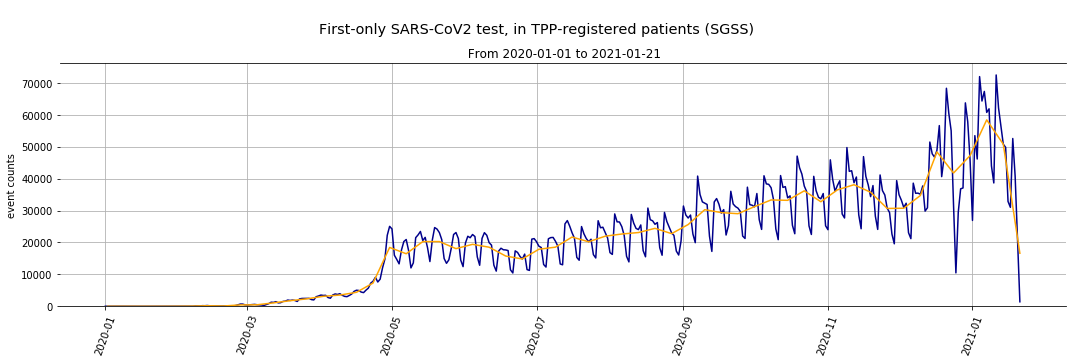

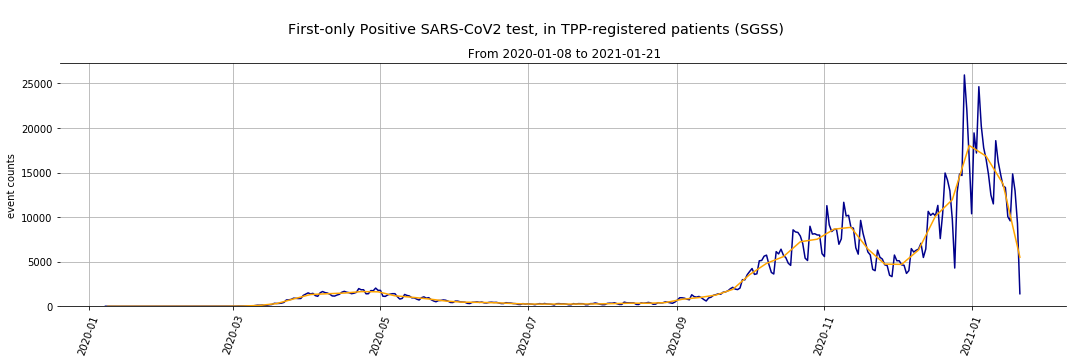

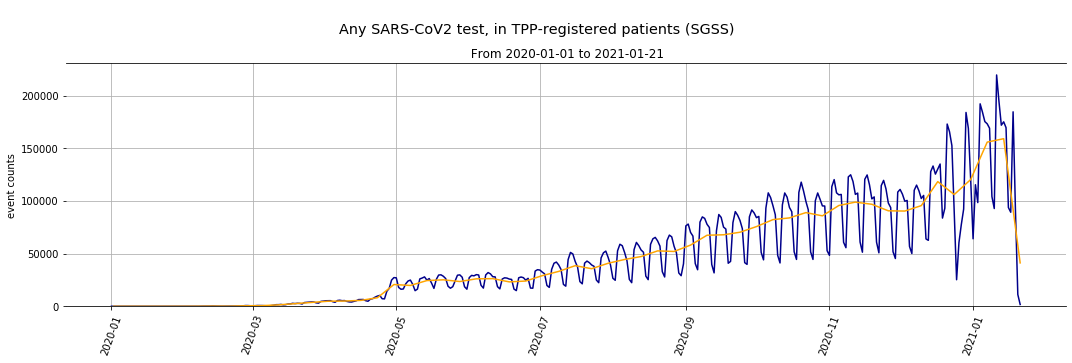

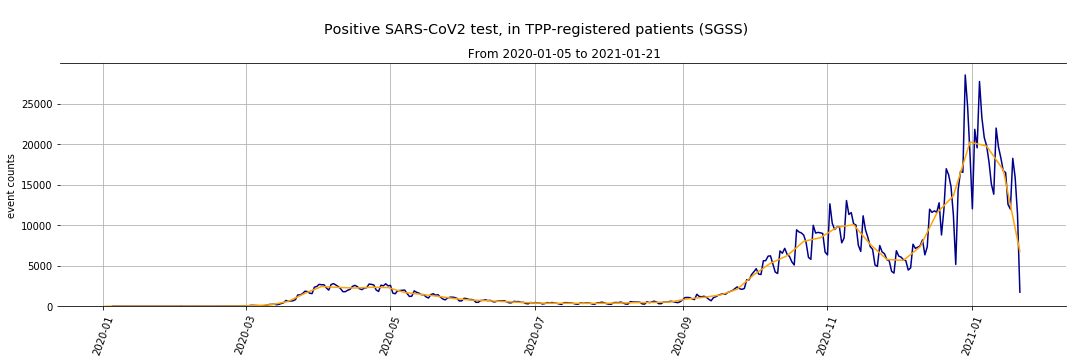

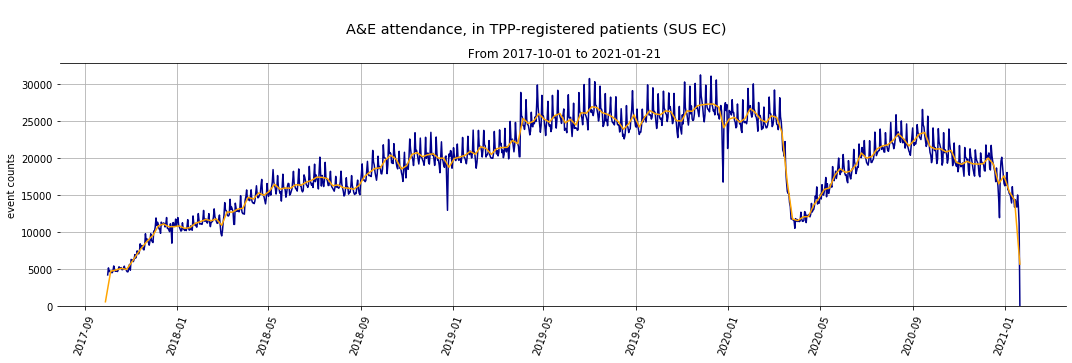

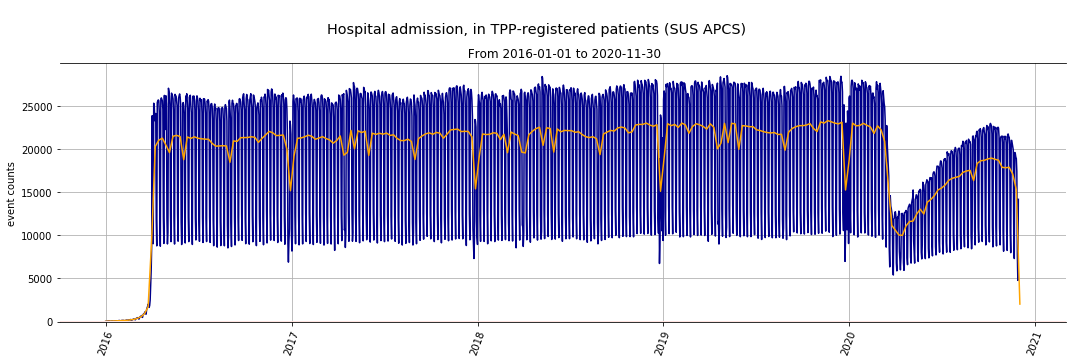

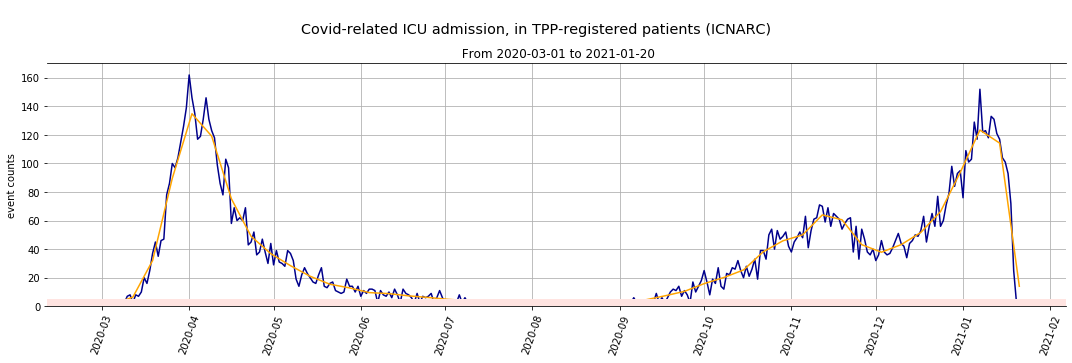

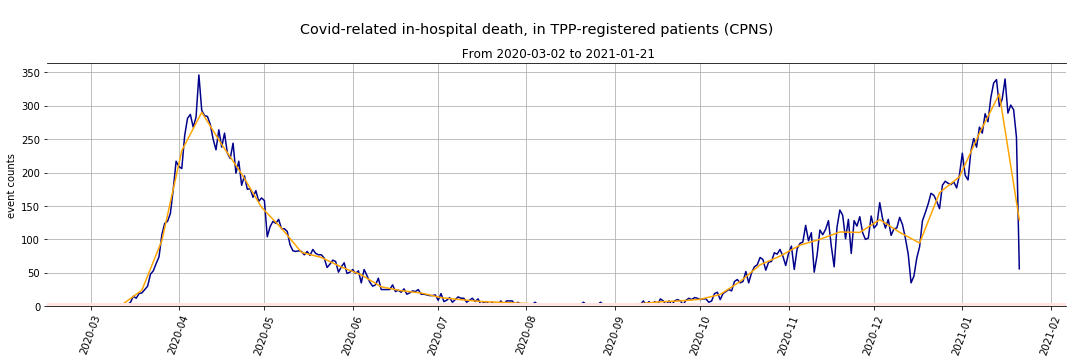

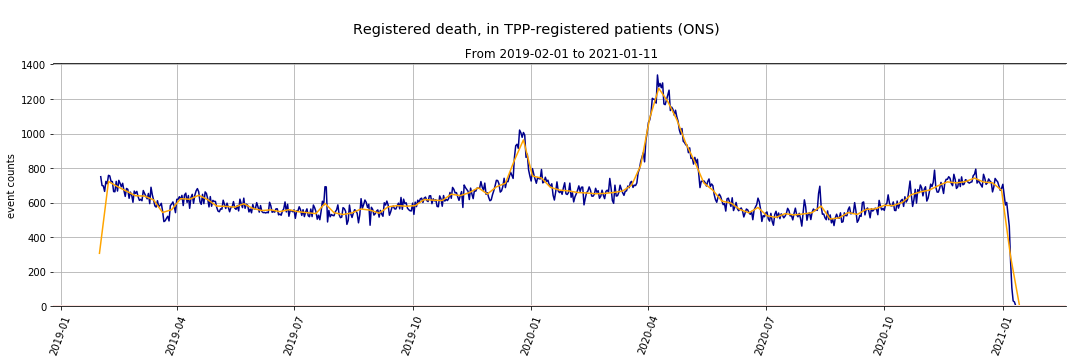

In [6]:
#plotcounts_history(CodedEvent_df['coded_event_date'], title="Any coded event in Primary Care, from SystmOne")
plotcounts_history(SGSS_df['specimen_date'], title="First-only SARS-CoV2 test, in TPP-registered patients (SGSS)")
plotcounts_history(SGSSpos_df['specimen_date'], title="First-only Positive SARS-CoV2 test, in TPP-registered patients (SGSS)")
plotcounts_history(SGSS_all_df['specimen_date'], title="Any SARS-CoV2 test, in TPP-registered patients (SGSS)")
plotcounts_history(SGSSpos_all_df['specimen_date'], title="Positive SARS-CoV2 test, in TPP-registered patients (SGSS)")
plotcounts_history(EC_df['ed_attendance_date'], title="A&E attendance, in TPP-registered patients (SUS EC)")
plotcounts_history(APCS_df['hosp_admission_date'], title="Hospital admission, in TPP-registered patients (SUS APCS)")
plotcounts_history(ICNARC_df['icu_admission_date'], title="Covid-related ICU admission, in TPP-registered patients (ICNARC)")
plotcounts_history(CPNS_df['cpns_death_date'], title="Covid-related in-hospital death, in TPP-registered patients (CPNS)")
plotcounts_history(ONS_df['ons_death_date'], title="Registered death, in TPP-registered patients (ONS)")